In [ ]:
import sys, os, re, json
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
from sklearn.model_selection import train_test_split

In [ ]:
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
!pip install datasets
from datasets import load_dataset
dataset_train=load_dataset("yelp_review_full",split='train')
dataset_test=load_dataset("yelp_review_full",split='test')
# Column names
column_names = ['star', 'review']

# Extract features 
data_train = {'star': dataset_train['label'], 'review': dataset_train['text']}
data_test = {'star': dataset_test['label'], 'review': dataset_test['text']}

# Convert to DataFrame Pandas
data_train = pd.DataFrame(data_train, columns=column_names)
data_test = pd.DataFrame(data_test, columns=column_names)

We have a datataset containing two features:
- *text*: the current review
- *label*: the current star reting

In [33]:
print(data_train.head(10))

   star                                             review
0     4  dr. goldberg offers everything i look for in a...
1     1  Unfortunately, the frustration of being Dr. Go...
2     3  Been going to Dr. Goldberg for over 10 years. ...
3     3  Got a letter in the mail last week that said D...
4     0  I don't know what Dr. Goldberg was like before...
5     4  Top notch doctor in a top notch practice. Can'...
6     4  Dr. Eric Goldberg is a fantastic doctor who ha...
7     0  I'm writing this review to give you a heads up...
8     1  Wing sauce is like water. Pretty much a lot of...
9     2  Decent range somewhat close to the city.  The ...

   star                                             review
0     0  I got 'new' tires from them and within two wee...
1     0  Don't waste your time.  We had two different p...
2     0  All I can say is the worst! We were the only 2...
3     0  I have been to this restaurant twice and was d...
4     0  Food was NOT GOOD at all! My husband & I ate h

# Data distribution
we should rating distribution here

In [35]:
data_train["star"].value_counts(normalize=False)

star
4    130000
1    130000
3    130000
0    130000
2    130000
Name: count, dtype: int64

In [7]:
def plot_labels(df, title=None):
  ds_labels = df["star"].value_counts(normalize=True)
  ds_labels.sort_index(inplace=True)
  plt.figure(figsize=(4,3))
  ax = ds_labels.plot(kind="bar")
  ax.set_xlabel("Star-" + title)
  ax.set_ylabel("Ratio")
  if title is not None:
    plt.savefig(title + ".eps")
  plt.show()

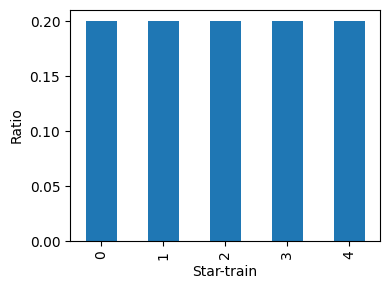

In [99]:
plot_labels(data_train, "train")

We can find that the dataset is balanced.

# Data Preprocessing and split
We need to seperate training, validation, and testing sets.

#### Removing emoticons

We will shortly train a classifier to detect stars rating.
- Before doing so, it is best to remove the emoticons and other symbols to make the classifier more stable.

In [12]:
def clean_sentence(sentence):
    sentence = re.sub(r'\\n',"",sentence)

    #removing emoticons
    sentence = re.sub(r'(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)',"", sentence)

    #removing websites
    sentence = re.sub(r"(http)?s?:?\/\/[A-Za-z0-9^,!.\/'+-=_?]+", "", sentence)

    #numbers
    sentence = re.sub(r"(\d+)(k)", r"\g<1> thousand", sentence)
    sentence = re.sub(r"(\d+)([a-zA-z]+)", r"\g<1> \g<2>", sentence)
    #convert numbers to words
    sentence = re.sub(r"1", " one ", sentence)
    sentence = re.sub(r"2", " two ", sentence)
    sentence = re.sub(r"3", " three ", sentence)
    sentence = re.sub(r"4", " four ", sentence)
    sentence = re.sub(r"5", " five ", sentence)
    sentence = re.sub(r"6", " six ", sentence)
    sentence = re.sub(r"7", " seven ", sentence)
    sentence = re.sub(r"8", " eight ", sentence)
    sentence = re.sub(r"9", " nine ", sentence)
    sentence = re.sub(r"0", " zero ", sentence)

    # removing extraneous symbols
    sentence = re.sub(r"[^A-Za-z0-9^,!.\/'+-=%]", " ", sentence)

    # expanding contraction
    sentence = re.sub(r"\'s", " is ", sentence)
    sentence = re.sub(r"\'ve", " have ", sentence)
    sentence = re.sub(r"n't", " not ", sentence)
    sentence = re.sub(r"i'm", " i am ", sentence)
    sentence = re.sub(r"\'re", " are ", sentence)
    sentence = re.sub(r"\'d", " would ", sentence)
    sentence = re.sub(r"\'ll", " will ", sentence)

    #spacing out symbols
    sentence = re.sub(r",", " ", sentence)
    sentence = re.sub(r"\.", " . ", sentence)
    sentence = re.sub(r"!", " ! ", sentence)
    sentence = re.sub(r"\/", " ", sentence)
    sentence = re.sub(r"\^", " ^ ", sentence)
    sentence = re.sub(r"\+", " + ", sentence)
    sentence = re.sub(r"\-", " - ", sentence)
    sentence = re.sub(r"\=", " = ", sentence)
    sentence = re.sub(r"'", " ", sentence)
    sentence = re.sub(r":", " : ", sentence)
    sentence = re.sub(r"%", " : ", sentence)

    return sentence


texts_train_cleaned = list(map(clean_sentence, data_train['review']))
texts_test_cleaned = list(map(clean_sentence, data_test['review']))

In [75]:
print("############# BEFORE CLEANING ###############")
np.random.seed(42)
for i in range(5):
  indexes = np.where(np.array(data_train["star"])==i)[0]  
  print(f"{i} stars: {data_train['review'][np.random.choice(indexes)]}\n")
    
print("\n############# AFTER CLEANING #############")
np.random.seed(42)
for i in range(5):
  indexes = np.where(np.array(data_train["star"])==i)[0]
  print(f"{i} stars: {texts_train_cleaned[np.random.choice(indexes)]}\n")

############# BEFORE CLEANING ###############
0 stars: We just came here with a large group and got kicked out bc we apparently refused to pay our tabs and were over intoxicated.  Umm, I personally paid $123 of overcharged drinks for my friends. We paid whatever charges they said we were refusing and left. We will never go there again. Take your money somewhere else that will at least treat you nicely. The drinks were overpriced and the service was horrible.  Don't waste your time and money.

1 stars: Ordered chicken pad thai and the thai wonton soup. Definitely had better. For the price, was disappointed. Still trying to find a really good Thai place in this city.

2 stars: BF and I went here at 9pm on a Friday night, when they closed at 10, and I have to say everyone was very nice, considering they probably wanted to wrap up and leave. \n\nPlus, my chicken egg roll was amazing. BF's general tso shrimp was very good. \n\nMinus, we each got a very little bowl of rice, and when we packe

In [13]:
X_train, X_val, y_train, y_val = train_test_split(texts_train_cleaned, data_train['star'], test_size=0.2, random_state=42,stratify = data_train['star'])
df_train = pd.DataFrame(data = {'review':X_train,'star':y_train})
df_train.reset_index(drop=True, inplace=True)
df_val = pd.DataFrame(data = {'review':X_val,'star':y_val})
df_val.reset_index(drop=True, inplace=True)
df_test = pd.DataFrame(data = {'review':texts_test_cleaned,'star':data_test['star']})
df_test.reset_index(drop=True, inplace=True)

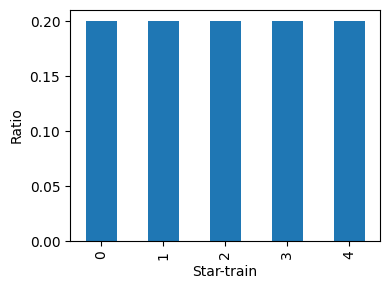

star
1    104000
4    104000
3    104000
2    104000
0    104000
Name: count, dtype: int64

In [103]:
plot_labels(df_train, "train")
df_train["star"].value_counts(normalize=False)

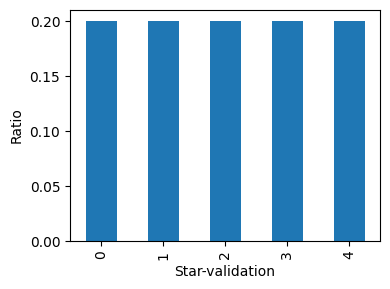

star
0    26000
4    26000
1    26000
3    26000
2    26000
Name: count, dtype: int64

In [104]:
plot_labels(df_val, "validation")
df_val["star"].value_counts(normalize=False)

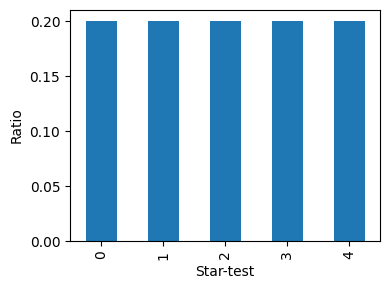

star
0    10000
2    10000
1    10000
3    10000
4    10000
Name: count, dtype: int64

In [105]:
plot_labels(df_test, "test")
df_test["star"].value_counts(normalize=False)

### Tokenization
In this part, we will tokenize reviews and count numbers of tokens for each review. This information will be useful in BERT model. But we will not use these tokens directly for training models.

In [ ]:
from nltk.tokenize import word_tokenize

In [107]:
ds_temp = df_train["review"].iloc[:10].map(lambda text: text.split())
print(df_train["review"].iloc[0], '\n', ds_temp.iloc[0])

Just went to Taste for lunch .   Well we will get this out of the way firs  the food is good and fresh .   Everything in there is shiny new and clean and sleek .   However  after getting the soup and sandwich combo with a drink  I am STILL HUNGRY .   And I paid over ten bucks !   The sandwich is a half in the combo  -  which means MINI  we are talking three bites .   Those three bites were good  however for   five  .  nine  nine  today at Jersey Mikes I would have had a huge sandwich AND chips AND a drink .   So  -  overall I think they should have toned down the chic - ness and tried to price their food better !  
 ['Just', 'went', 'to', 'Taste', 'for', 'lunch', '.', 'Well', 'we', 'will', 'get', 'this', 'out', 'of', 'the', 'way', 'firs', 'the', 'food', 'is', 'good', 'and', 'fresh', '.', 'Everything', 'in', 'there', 'is', 'shiny', 'new', 'and', 'clean', 'and', 'sleek', '.', 'However', 'after', 'getting', 'the', 'soup', 'and', 'sandwich', 'combo', 'with', 'a', 'drink', 'I', 'am', 'STILL

In [108]:
%time df_train["tokens"] = df_train["review"].map(lambda text: text.split())

CPU times: user 10.3 s, sys: 4.05 s, total: 14.4 s
Wall time: 14.4 s


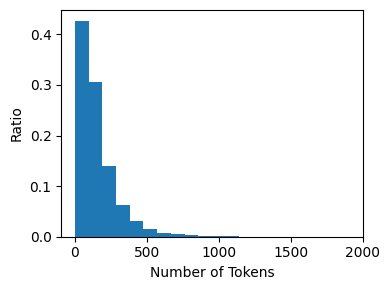

In [122]:
df_train["num_tokens"] = df_train["tokens"].map(len)
ax = df_train["num_tokens"].hist(bins=20, 
                                 figsize=(4,3),
                                 grid = False,
                                 weights=np.ones(df_train.shape[0])/df_train.shape[0])
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Ratio")
plt.tight_layout()
plt.show()

In [124]:
print(len(df_train[df_train["num_tokens"] <= 128]) / len(df_train["num_tokens"]))
print(len(df_train[df_train["num_tokens"] <= 256]) / len(df_train["num_tokens"]))

0.5597769230769231
0.8397557692307692


In [ ]:
df_train.drop(columns=['num_tokens'], inplace=True)

From the result, we can see most reviews are shorter than 256 tokens.

### Vectorization
We will try following settings for vectorization:
- Word representation: CountVectorizer vs. TfidfVectorizer
- N-grams: unigram & bigram
- Minimum document frequency: 5
- Convert to lowercase
- Use stop words

In [ ]:
%time X_train, X_dev, X_test, y_train, y_dev, y_test = extract_features(df_train, df_val, df_test)

# Experiments and Results
We will use machine learning models and transformer-based models
### Machine Learning
Navie Bayes, Logistic Regression, Random Forest, and SGD Classifier will used in this section.

#### Evaluation Metrics
- Precision, recall, F1 score
- Accuracy
- Confusion matrix

In [137]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [153]:
def evaluate_model_Xy(model, X, y, y_pred=None, label="Training", model_name="model"):
  if y_pred is None:
    y_pred = model.predict(X)

  print(label + ' Set')
  print("Accuracy:", accuracy_score(y, y_pred))
  print()

  print(classification_report(y, y_pred, digits=4))
  disp = confusion_matrix(y, y_pred, 
                          normalize='true')
  sns.heatmap(disp, annot=True, fmt=".2f", cmap="Blues")
  plt.savefig(model_name + "_" + label.lower() + ".eps")
  plt.show()
  print()

In [154]:
def evaluate_model(model, model_name="model",
                   y_train_pred=None, y_dev_pred=None, y_test_pred=None):
  evaluate_model_Xy(model, X_train, y_train, label="Training", model_name=model_name)
  evaluate_model_Xy(model, X_dev, y_dev, label="Validation", model_name=model_name)
  evaluate_model_Xy(model, X_test, y_test, label="Testing", model_name=model_name)

### Naive Bayes Classifier

In [182]:
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB(alpha=0.5
                      )


In [183]:
%time clf_nb.fit(X_train, y_train)

CPU times: user 5.7 s, sys: 358 ms, total: 6.06 s
Wall time: 2.02 s


MultinomialNB(alpha=0.5)

Training Set
Accuracy: 0.7580038461538462

              precision    recall  f1-score   support

           0     0.7267    0.7877    0.7560    104000
           1     0.7174    0.7013    0.7092    104000
           2     0.7723    0.7461    0.7590    104000
           3     0.7414    0.7832    0.7617    104000
           4     0.8425    0.7718    0.8056    104000

    accuracy                         0.7580    520000
   macro avg     0.7601    0.7580    0.7583    520000
weighted avg     0.7601    0.7580    0.7583    520000



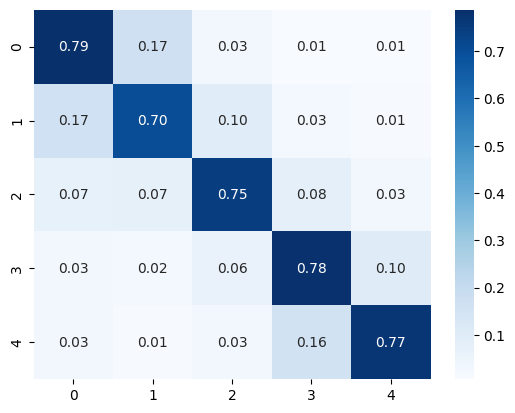


Validation Set
Accuracy: 0.5554846153846154

              precision    recall  f1-score   support

           0     0.6391    0.6998    0.6681     26000
           1     0.4972    0.4777    0.4872     26000
           2     0.4836    0.4795    0.4816     26000
           3     0.4812    0.5301    0.5044     26000
           4     0.6936    0.5903    0.6378     26000

    accuracy                         0.5555    130000
   macro avg     0.5589    0.5555    0.5558    130000
weighted avg     0.5589    0.5555    0.5558    130000



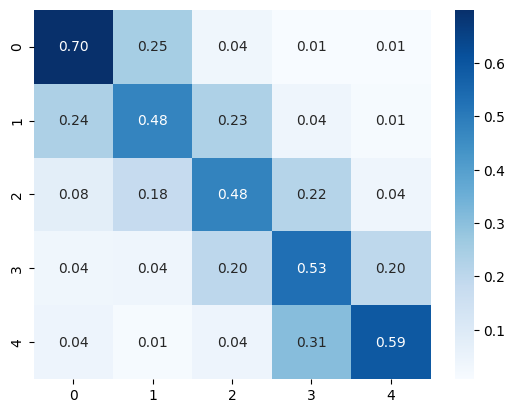


Testing Set
Accuracy: 0.55294

              precision    recall  f1-score   support

           0     0.6300    0.6853    0.6565     10000
           1     0.4921    0.4760    0.4839     10000
           2     0.4862    0.4790    0.4826     10000
           3     0.4846    0.5399    0.5107     10000
           4     0.6912    0.5845    0.6334     10000

    accuracy                         0.5529     50000
   macro avg     0.5568    0.5529    0.5534     50000
weighted avg     0.5568    0.5529    0.5534     50000



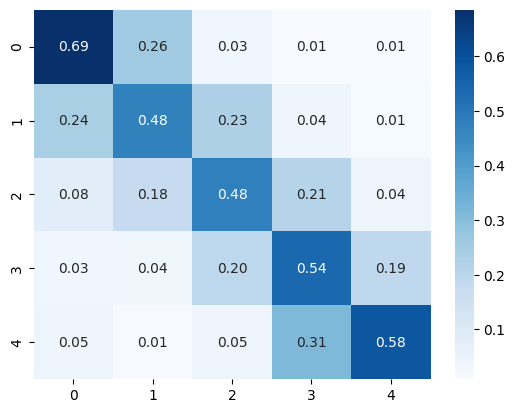

In [184]:
evaluate_model(clf_nb, model_name="nb")

### Logistic Regression Classifier-Lasso

In [168]:

clf_lr_lasso = LogisticRegression(penalty='l2',
                                  tol=1e-4,
                                  C=5.0,
                                  fit_intercept=True,
                                  class_weight='balanced',
                                  random_state=0,
                                  solver='lbfgs',
                                  max_iter=500,
                                  multi_class='auto',
                                  verbose=1,
                                  n_jobs=-1)

In [ ]:
clf_lr_lasso.fit(X_train, y_train)

Training Set
Accuracy: 0.9579153846153846

              precision    recall  f1-score   support

           0     0.9613    0.9748    0.9680    104000
           1     0.9600    0.9540    0.9570    104000
           2     0.9563    0.9435    0.9498    104000
           3     0.9552    0.9481    0.9517    104000
           4     0.9567    0.9692    0.9629    104000

    accuracy                         0.9579    520000
   macro avg     0.9579    0.9579    0.9579    520000
weighted avg     0.9579    0.9579    0.9579    520000



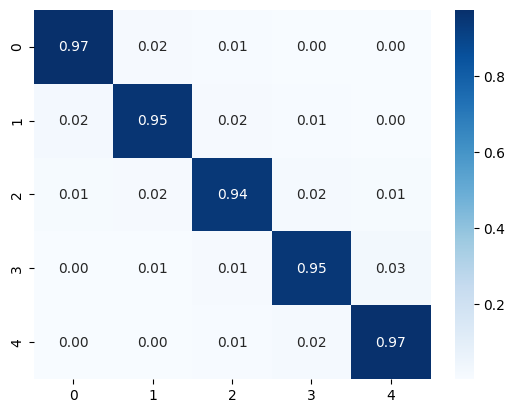


Validation Set
Accuracy: 0.583176923076923

              precision    recall  f1-score   support

           0     0.7152    0.7466    0.7306     26000
           1     0.5260    0.5076    0.5167     26000
           2     0.4986    0.4837    0.4910     26000
           3     0.4948    0.4908    0.4928     26000
           4     0.6677    0.6873    0.6773     26000

    accuracy                         0.5832    130000
   macro avg     0.5805    0.5832    0.5817    130000
weighted avg     0.5805    0.5832    0.5817    130000



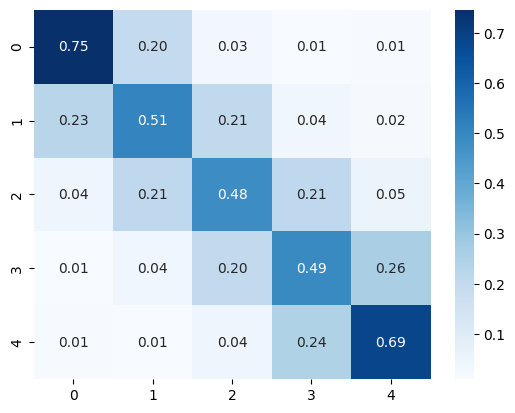


Testing Set
Accuracy: 0.57932

              precision    recall  f1-score   support

           0     0.7073    0.7393    0.7230     10000
           1     0.5194    0.5035    0.5113     10000
           2     0.4952    0.4838    0.4895     10000
           3     0.4936    0.4888    0.4912     10000
           4     0.6690    0.6812    0.6750     10000

    accuracy                         0.5793     50000
   macro avg     0.5769    0.5793    0.5780     50000
weighted avg     0.5769    0.5793    0.5780     50000



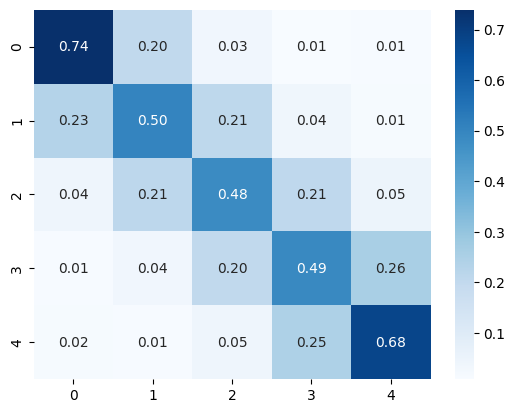

In [158]:
evaluate_model(clf_lr_lasso, model_name="lr_tfidf_lasso")

### Random Forest Classifier

In [162]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=500,
                                criterion="gini",
                                max_depth=None, 
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features="auto", 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [163]:
clf_rf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.3min finished


RandomForestClassifier(class_weight='balanced', max_features='auto',
                       min_samples_leaf=10, n_estimators=500, n_jobs=-1,
                       random_state=0, verbose=1)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  3.9min finished


Training Set
Accuracy: 0.5955423076923076

              precision    recall  f1-score   support

           0     0.6020    0.8221    0.6950    104000
           1     0.6029    0.4563    0.5195    104000
           2     0.6021    0.4899    0.5403    104000
           3     0.5715    0.4786    0.5210    104000
           4     0.5959    0.7307    0.6564    104000

    accuracy                         0.5955    520000
   macro avg     0.5949    0.5955    0.5864    520000
weighted avg     0.5949    0.5955    0.5864    520000



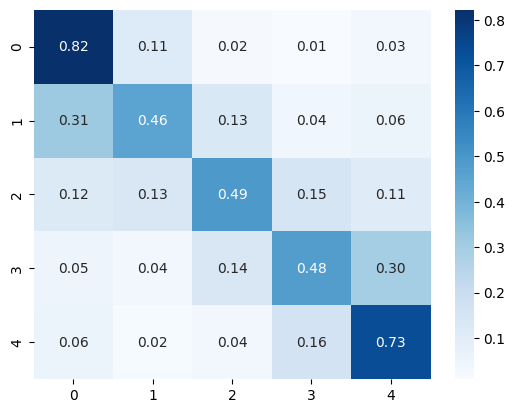

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   53.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   59.9s finished


Validation Set
Accuracy: 0.5327692307692308

              precision    recall  f1-score   support

           0     0.5759    0.8038    0.6711     26000
           1     0.5098    0.3832    0.4376     26000
           2     0.4942    0.3982    0.4410     26000
           3     0.4772    0.3912    0.4300     26000
           4     0.5602    0.6874    0.6173     26000

    accuracy                         0.5328    130000
   macro avg     0.5235    0.5328    0.5194    130000
weighted avg     0.5235    0.5328    0.5194    130000



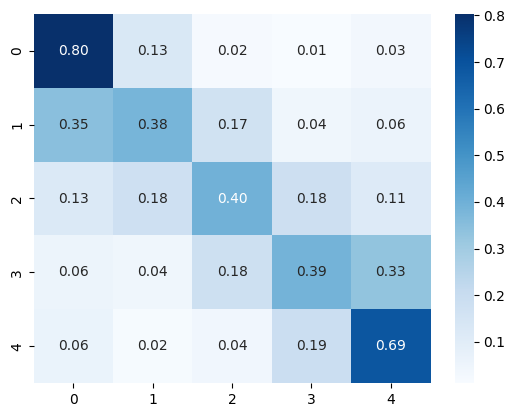

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:   22.8s finished


Testing Set
Accuracy: 0.531

              precision    recall  f1-score   support

           0     0.5731    0.7993    0.6675     10000
           1     0.5094    0.3832    0.4374     10000
           2     0.4945    0.3970    0.4404     10000
           3     0.4727    0.3918    0.4285     10000
           4     0.5599    0.6837    0.6156     10000

    accuracy                         0.5310     50000
   macro avg     0.5219    0.5310    0.5179     50000
weighted avg     0.5219    0.5310    0.5179     50000



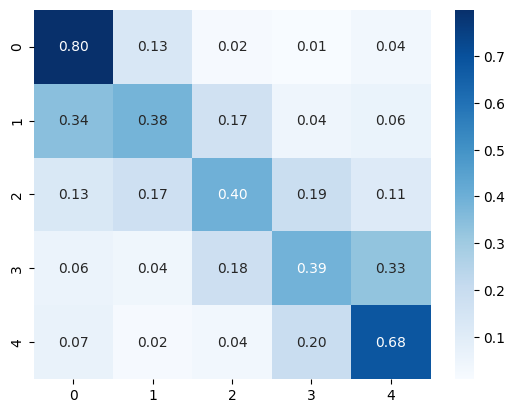

In [164]:
evaluate_model(clf_rf, model_name="rf")

### SGDClassifier

In [165]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf_sgd = make_pipeline(StandardScaler(with_mean=False),
                        SGDClassifier(loss='hinge',
                                      penalty='l2',
                                      alpha=30,
                                      max_iter=1000, 
                                      tol=1e-3,
                                      shuffle=True,
                                      verbose=1,
                                      n_jobs=-1,
                                      random_state=0,
                                      learning_rate='optimal',
                                      early_stopping=True,
                                      class_weight='balanced'))

In [166]:
clf_sgd.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


-- Epoch 1-- Epoch 1
-- Epoch 1

-- Epoch 1
Norm: 0.10, NNZs: 883316, Bias: -0.006211, T: 468000, Avg. loss: 0.569856
Total training time: 0.60 seconds.
-- Epoch 2
Norm: 0.10, NNZs: 885152, Bias: -0.005805, T: 468000, Avg. loss: 0.569962
Total training time: 0.67 seconds.
Norm: 0.11, NNZs: 880627, Bias: -0.006046, T: 468000, Avg. loss: 0.504718
Total training time: 0.67 seconds.
Norm: 0.10, NNZs: 879595, Bias: -0.005994, T: 468000, Avg. loss: 0.556671
Total training time: 0.66 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 0.10, NNZs: 884861, Bias: -0.006310, T: 936000, Avg. loss: 0.536765
Total training time: 1.26 seconds.
-- Epoch 3
Norm: 0.10, NNZs: 886346, Bias: -0.005906, T: 936000, Avg. loss: 0.536398
Total training time: 1.31 seconds.
Norm: 0.11, NNZs: 882990, Bias: -0.006140, T: 936000, Avg. loss: 0.473049
Total training time: 1.33 seconds.
Norm: 0.10, NNZs: 881931, Bias: -0.006089, T: 936000, Avg. loss: 0.525360
Total training time: 1.32 seconds.
-- Epoch 3
-- Epoch 3
-- Epoc

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=30, class_weight='balanced',
                               early_stopping=True, n_jobs=-1, random_state=0,
                               verbose=1))])

Training Set
Accuracy: 0.8175461538461538

              precision    recall  f1-score   support

           0     0.7128    0.9398    0.8107    104000
           1     0.8733    0.7010    0.7777    104000
           2     0.8871    0.7524    0.8142    104000
           3     0.8504    0.7875    0.8178    104000
           4     0.8212    0.9070    0.8620    104000

    accuracy                         0.8175    520000
   macro avg     0.8289    0.8175    0.8165    520000
weighted avg     0.8289    0.8175    0.8165    520000



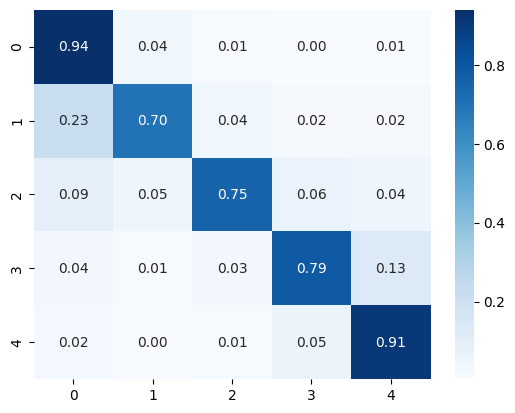


Validation Set
Accuracy: 0.5384

              precision    recall  f1-score   support

           0     0.5590    0.8331    0.6690     26000
           1     0.5187    0.3587    0.4241     26000
           2     0.5024    0.3669    0.4241     26000
           3     0.4683    0.4259    0.4461     26000
           4     0.6004    0.7075    0.6495     26000

    accuracy                         0.5384    130000
   macro avg     0.5297    0.5384    0.5226    130000
weighted avg     0.5297    0.5384    0.5226    130000



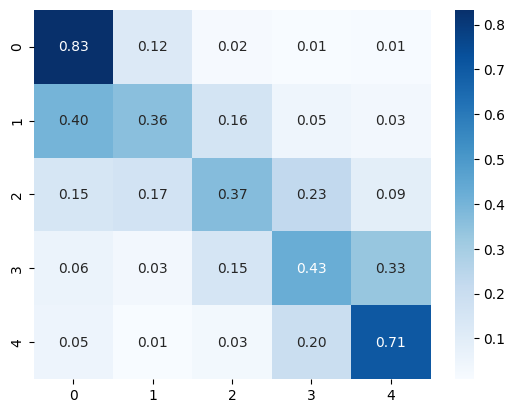


Testing Set
Accuracy: 0.53678

              precision    recall  f1-score   support

           0     0.5523    0.8227    0.6609     10000
           1     0.5140    0.3528    0.4184     10000
           2     0.5019    0.3656    0.4231     10000
           3     0.4703    0.4327    0.4507     10000
           4     0.6040    0.7101    0.6528     10000

    accuracy                         0.5368     50000
   macro avg     0.5285    0.5368    0.5212     50000
weighted avg     0.5285    0.5368    0.5212     50000



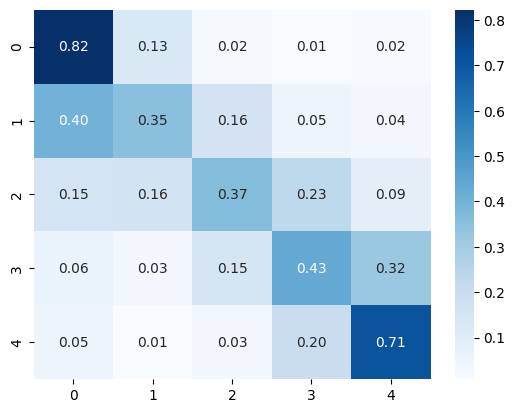

In [167]:
evaluate_model(clf_sgd, model_name="sgd")

## Deep Learning

Transformer-based models including *BERT*, *DistilBERT*, *RoBERTa*, and *XLNet* will be used in this section.

In [3]:
%pip install simpletransformers
from simpletransformers.classification import ClassificationModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 733.1 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 45.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=e379adbcfd657c6c14d004849197fd261d9464bd75308daffcfe7e44681e1e0f
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


2024-05-04 12:03:09.228630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 12:03:09.228729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 12:03:09.403049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [28]:
model_bert_base_cased_64 = \
ClassificationModel('bert',
                    'bert-base-cased',
                    num_labels=5,
                    args={"output_dir": "outputs_bert_base_cased_64/",
                          "best_model_dir": "outputs_bert_base_cased_64/best_model/",
                          "max_seq_length": 128,
                          "train_batch_size": 16,
                          "num_train_epochs": 3,
                          "logging_steps": 100,
                          "evaluate_during_training": True,
                          "evaluate_during_training_steps": 20000,
                          "evaluate_during_training_verbose": True,
                          "save_eval_checkpoints": False,
                          "save_steps": 20000,
                          "save_model_every_epoch": False,
                          "overwrite_output_dir": True,
                          "reprocess_input_data": False,
                          "use_cuda ": True})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_bert_base_cased_64.train_model(df_train.iloc[1:2],eval_df = df_val)

/opt/conda/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/260 [00:00<?, ?it/s]